<a href="https://colab.research.google.com/github/pradumnyakshirsagar2811/Time-Serie-Analysis/blob/main/Zidio_time_series_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

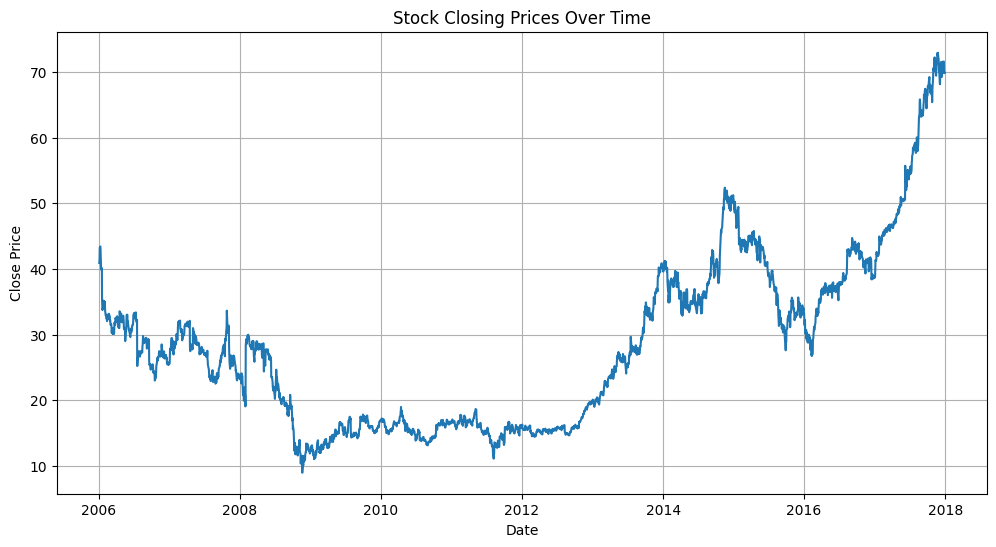

ADF Statistic: 0.3957
p-value: 0.9813


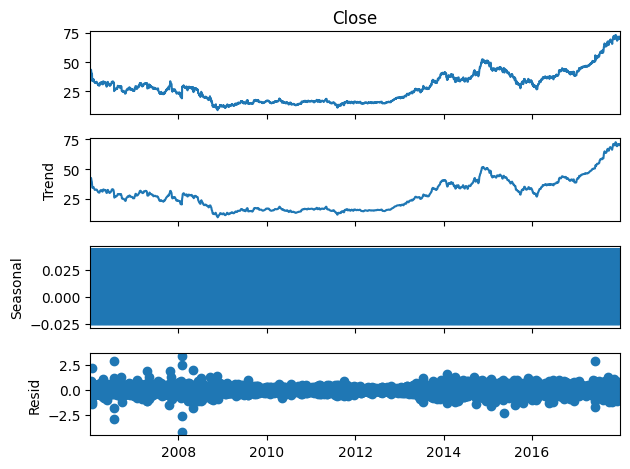

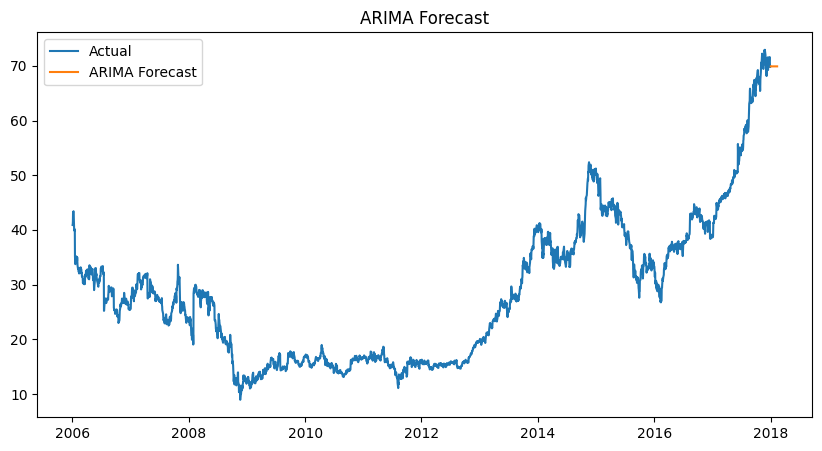

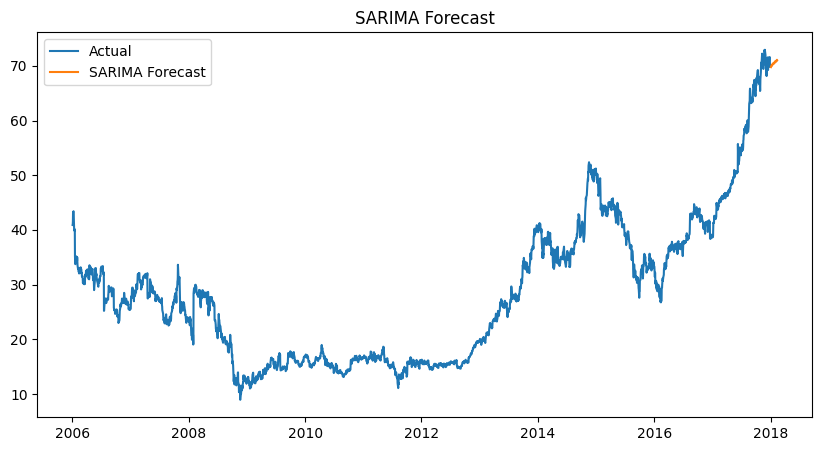

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_fbv3b0/gke_u_a_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_fbv3b0/hda2k56e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65105', 'data', 'file=/tmp/tmp6_fbv3b0/gke_u_a_.json', 'init=/tmp/tmp6_fbv3b0/hda2k56e.json', 'output', 'file=/tmp/tmp6_fbv3b0/prophet_modelt33lrwzq/prophet_model-20250521110501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:05:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:05:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


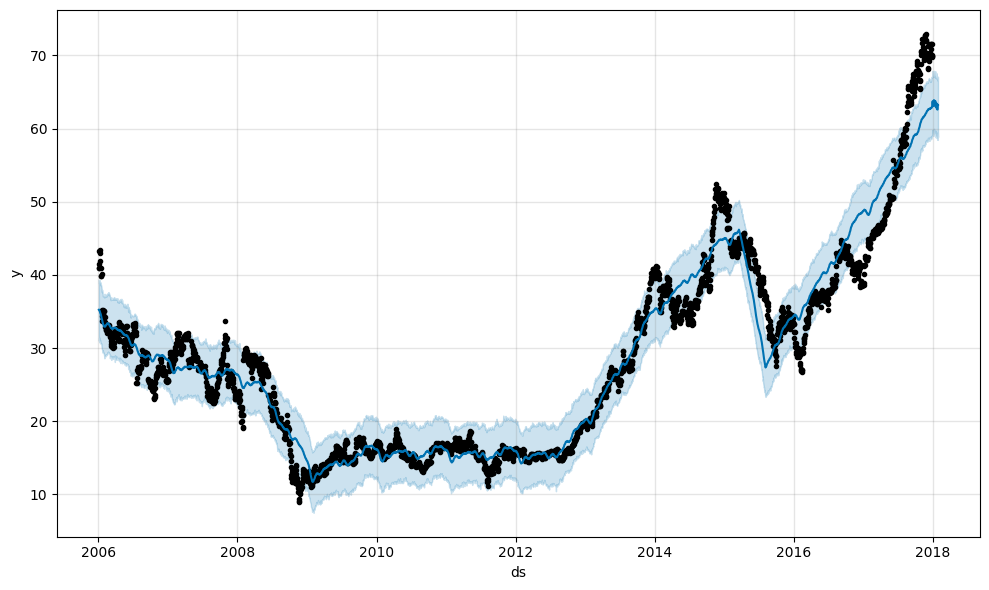

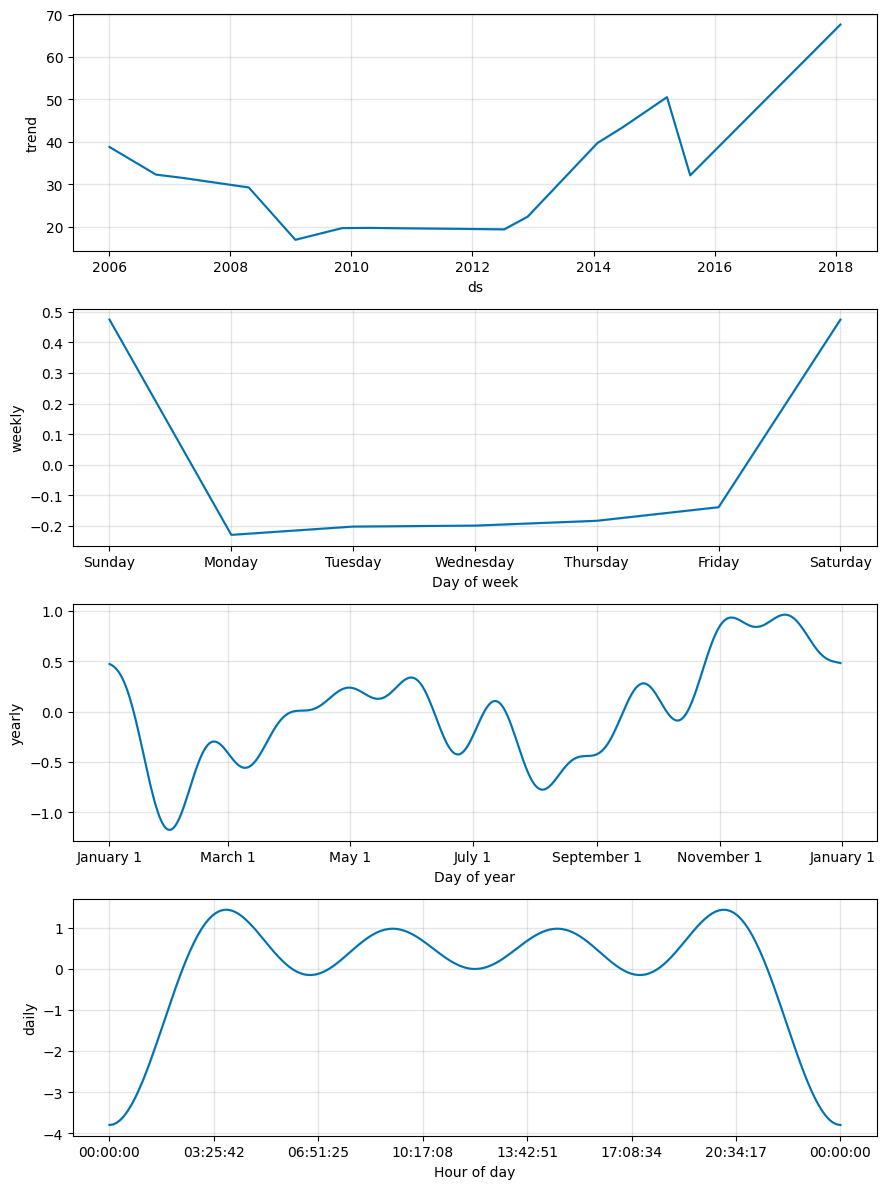

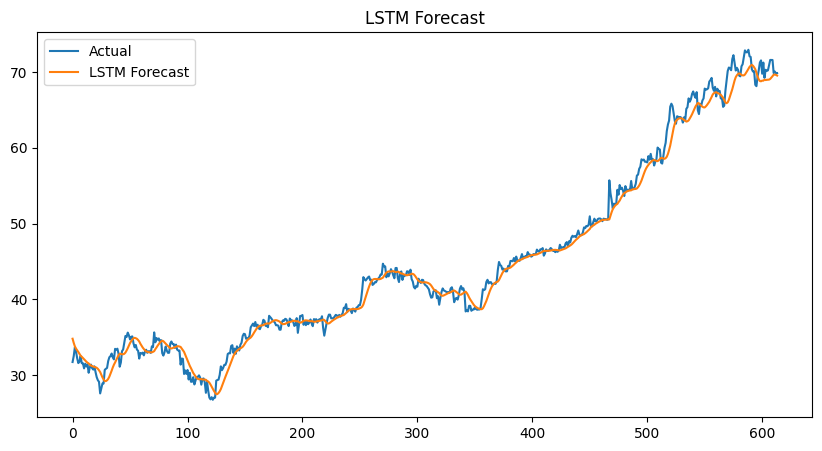


ARIMA Evaluation:
RMSE: 1.5136
MAE : 1.1718
MAPE: 1.64%

SARIMA Evaluation:
RMSE: 1.4872
MAE : 1.2158
MAPE: 1.71%

Prophet Evaluation:
RMSE: 7.6731
MAE : 7.5677
MAPE: 10.67%

LSTM Evaluation:
RMSE: 1.7703
MAE : 1.5071
MAPE: 2.12%

Model Comparison:
             RMSE       MAE   MAPE (%)
ARIMA    1.513557  1.171817   1.639741
SARIMA   1.487228  1.215845   1.710759
Prophet  7.673067  7.567669  10.669536
LSTM     1.770268  1.507050   2.115637


In [ ]:
!pip install -q prophet tensorflow plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# Load and clean column names
df = pd.read_csv('/content/Historic_stock_data.csv')
df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace

# Check if 'Date' column exists
if 'Date' not in df.columns:
    raise KeyError("The dataset must contain a 'Date' column.")

# Parse dates
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Filter for 'Close' only
df = df[['Close']]
df = df.asfreq('B').fillna(method='ffill')

plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


result = adfuller(df['Close'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")


decomposition = seasonal_decompose(df['Close'], model='additive')
decomposition.plot()
plt.show()


forecast_steps = 30
future_dates = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='B')[1:]

arima_model = ARIMA(df['Close'], order=(5,1,0))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=forecast_steps)

plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Actual')
plt.plot(future_dates, arima_pred, label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

# SARIMA Model
sarima_model = SARIMAX(df['Close'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()
sarima_pred = sarima_result.forecast(forecast_steps)

plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Actual')
plt.plot(future_dates, sarima_pred, label='SARIMA Forecast')
plt.legend()
plt.title("SARIMA Forecast")
plt.show()

#  Prophet Model
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=forecast_steps)
forecast = prophet_model.predict(future)

# Plot
prophet_model.plot(forecast)
prophet_model.plot_components(forecast)

#  LSTM Model
data = df.values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

seq_len = 60
X, y = [], []
for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

# Split data
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Predict
lstm_pred = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_actual = scaler.inverse_transform(y_test)

plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label='Actual')
plt.plot(lstm_pred, label='LSTM Forecast')
plt.legend()
plt.title("LSTM Forecast")
plt.show()

# Evaluation Metrics
def evaluate_model(true, pred, name):
    rmse = sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    print(f"\n{name} Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    return rmse, mae, mape

# Slice ground truth
truth = df['Close'][-forecast_steps:].values

# Evaluate all models
eval_results = {}
eval_results['ARIMA'] = evaluate_model(truth, arima_pred, "ARIMA")
eval_results['SARIMA'] = evaluate_model(truth, sarima_pred, "SARIMA")
eval_results['Prophet'] = evaluate_model(truth, forecast['yhat'][-forecast_steps:].values, "Prophet")
eval_results['LSTM'] = evaluate_model(y_test_actual[-forecast_steps:], lstm_pred[-forecast_steps:], "LSTM")

# Compare All Models
eval_df = pd.DataFrame(eval_results, index=['RMSE', 'MAE', 'MAPE (%)']).T
print("\nModel Comparison:")
print(eval_df)
